In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from itertools import product
from functools import reduce
from sklearn.cluster import MiniBatchKMeans, KMeans
import glob
import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
X = pd.read_csv('data/X_without_lags_and_target_encoding.csv')
y = pd.read_csv('data/y_without_lags_and_target_encoding.csv').item_cnt
X_test = pd.read_csv('data/test_without_lags_and_target_encoding.csv', index_col='ID')

In [3]:
types = {
    'date_block_num': 'int8',
    'shop_id': 'int8',
    'item_id': 'int16',
    'item_category_id': 'int8',
    'super_category': 'int8',
    'category': 'int8',
    'city': 'int8',
    'shop_type': 'int8',
    'shop_name': 'int8'
}
X = X.astype(types)
X_test = X_test.astype(types)

In [4]:
X_train = X[X.date_block_num < 33]
y_train = y[X.date_block_num < 33]

X_val = X[X.date_block_num == 33]
y_val = y[X.date_block_num == 33]

# Some functions

In [5]:
def RMSE(series_true, series_predicted):
    true = np.array(series_true)
    predicted = np.array(series_predicted)
    return sum((true - predicted)**2 / len(true))**0.5

In [6]:
def EMA(ser, alpha):
    y_1 = ser[0]
    for y in ser:
        y_1 = (1 - alpha) * y_1 + alpha * y
    return y_1

In [7]:
def submit(y_predicted):
    my_submissions_paths = glob.glob('./data/my_submission_*.csv')
    nums = [int(re.findall(r'\d+', filepath)[0]) for filepath in my_submissions_paths]
    n = max(nums) + 1
    submission = pd.read_csv('data/sample_submission.csv')
    submission.item_cnt_month = y_predicted
    submission.to_csv(f'data/my_submission_{n}.csv', index=None)
    return f'data/my_submission_{n}.csv'

In [8]:
all_series = pd.read_pickle('data/all_series.pickle', compression='bz2')

In [9]:
all_series.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training models

### class MyAbstractModel

The interface of classes.  
The *fit* method extract all time series for each (shop_id, item_id) element.  
The *predict_shop_item* method returns the prediction for one (shop_id, item_id) element.  
The *predict* method returns the array of clipped predictions for each of the (shop_id, item_id) element.  

In [10]:
class MyAbstractModel:

    def __init__(self, model_init, n_clusters=100, *model_args, **model_kwargs):
        self.model_init = model_init
        self.n_clusters = n_clusters
        self.model_args = model_args
        self.model_kwargs = model_kwargs

    def _fit_cluster_model(self, X_tseries, model_num):
        pass

    def fit(self, X_train, y_train):
        X = X_train.copy()
        X['target'] = y_train
        self.all_series = X.groupby(
            ['shop_id', 'item_id', 'date_block_num']).target.sum().unstack(fill_value=0).clip(0, 20)

        if self.n_clusters > 0:
            self.kmeans = MiniBatchKMeans(
                n_clusters=self.n_clusters, random_state=0)
            self.kmeans.fit(self.all_series)

        if self.model_init is None:
            self.cluster_models = [None] * self.n_clusters
            return
            
        self.cluster_models = []
        for i in range(self.n_clusters):
            X = self.all_series[self.kmeans.labels_ == i]
            model = self.model_init(*self.model_args, **self.model_kwargs)
            self.cluster_models.append(model)
            self._fit_cluster_model(X, i)

    def _predict_with_cluster_model(self, X, model_num):
        pass

#     def predict_shop_item(self, shop_id, item_id):
#         try:
#             ser = self.all_series.loc[[(shop_id, item_id)]]
#         except KeyError as e:
#             return 0

#         label = self.kmeans.predict(ser)[0]
#         return self._predict_with_cluster_model(ser, self.cluster_models[label])[0]

    def predict(self, X):
        sers = self.all_series.merge(X[['shop_id', 'item_id']], on=['shop_id', 'item_id'], how='right')\
            .fillna(0).drop(columns=['shop_id', 'item_id'])
        prediction = pd.DataFrame({'target': np.zeros(len(sers))})
        prediction['cluster'] = self.kmeans.predict(sers)
        for cluster in prediction.cluster.unique():
            prediction.target[(prediction.cluster == cluster).values] = self._predict_with_cluster_model(
                sers[(prediction.cluster == cluster).values],
                cluster)
        return prediction.target.clip(0, 20)

## Model with lag features

In [47]:
class ModelWithLags(MyAbstractModel):
    
    def __init__(self, model_init, n_clusters=100, window=12, scale=False, *model_args, **model_kwargs):
        MyAbstractModel.__init__(self, model_init, n_clusters, *model_args, **model_kwargs)
        self.window = window
        self.scale = scale
        if scale:
            self.scalers = [StandardScaler() for i in range(self.n_clusters)]
    
    def _fit_cluster_model(self, X_tseries, model_num):
        if len(X_tseries) == 0:
            return
        X_tseries = X_tseries.rename(columns=str).sample(min(1000, len(X_tseries)), random_state=0)
        
        X = pd.DataFrame({str(i): [] for i in range(self.window + 1)}, dtype='int8')
        for k in range(len(X_tseries.columns) - self.window):
            X = pd.concat([X, X_tseries.loc[:, str(k) : str(k + self.window)].set_axis(X.columns, axis=1)])
        
        X, y = X.drop(columns=str(self.window)), X[str(self.window)]
        if self.scale:
            X = self.scalers[model_num].fit_transform(X)
        self.cluster_models[model_num].fit(X, y)
    
    def _predict_with_cluster_model(self, X_tseries, model_num):
        X = X_tseries.rename(columns=str)
        X = X.loc[:, str(len(X.columns) - self.window) : str(len(X.columns) - 1)]
        if self.scale:
            X = self.scalers[model_num].transform(X)
        return self.cluster_models[model_num].predict(X)

## class ModelEMADefault

It expands the previous interface with the *predict_small_history* method which is used when the time series has a lot of zeros. The meaning of "a lot of zeros" is defined for each subclass (e.g. the number of zeros is greater than 20).

In [48]:
class ModelEMADefault(ModelWithLags):

    def __init__(self, model_init, n_clusters=100, window=12, scale=False, ema_koeff=0.4, ema_threshold=-12, *model_args, **model_kwargs):
        ModelWithLags.__init__(self, model_init, n_clusters, window, scale, *model_args, **model_kwargs)
        self.ema_koeff = ema_koeff
        self.ema_threshold = ema_threshold

    def _predict_small_history(self, X_tseries):
        return EMA(X_tseries.iloc[:, :self.ema_threshold].to_numpy().T, self.ema_koeff)
    
    def predict(self, X):
        sers = self.all_series.merge(X[['shop_id', 'item_id']], on=['shop_id', 'item_id'], how='right')\
            .fillna(0).drop(columns=['shop_id', 'item_id'])
        prediction = pd.DataFrame({'target': np.zeros(len(sers))})
        prediction['cluster'] = self.kmeans.predict(sers)
        for cluster in prediction.cluster.unique():
            prediction.target[(prediction.cluster == cluster).values] = self._predict_with_cluster_model(
                sers[(prediction.cluster == cluster).values],
                cluster)
        small_series = True
        for col in sers.iloc[:, :self.ema_threshold].columns:
            small_series &= (sers[col] == 0)
        prediction.target[small_series] = self._predict_small_history(sers[small_series])
        return prediction.target.clip(0, 20)

In [92]:
model_ema = ModelEMADefault(LGBMRegressor)

In [93]:
model_ema.fit(X_train, y_train)

In [94]:
model_ema_predicted = model_ema.predict(X_val)

In [95]:
RMSE(y_val, model_ema_predicted)

1.08448436644212

In [23]:
model = ModelWithLags(LGBMRegressor)

In [24]:
model.fit(X_train, y_train)

In [25]:
lgbm_predicted = model.predict(X_val)

In [26]:
RMSE(y_val, lgbm_predicted)

1.05011346992464

In [61]:
lin_reg_model = ModelWithLags(ElasticNet)

In [62]:
lin_reg_model.fit(X_train, y_train)

In [63]:
lin_reg_predicted = lin_reg_model.predict(X_val)

In [64]:
RMSE(y_val, lin_reg_predicted)

0.9911689580648018

In [65]:
scaled_lin_reg_model = ModelWithLags(ElasticNet, scale=True)

In [66]:
scaled_lin_reg_model.fit(X_train, y_train)

In [67]:
scaled_lin_reg_predicted = scaled_lin_reg_model.predict(X_val)

In [68]:
RMSE(y_val, scaled_lin_reg_predicted)

1.008301865559978

In [70]:
scaled_lin_reg_model.scalers[0].mean_

array([0.025     , 0.03042857, 0.03042857, 0.03528571, 0.03985714,
       0.04333333, 0.04333333, 0.04333333, 0.04752381, 0.05157143,
       0.04628571, 0.0522381 ])

In [73]:
scaled_lin_reg_model.scalers[0].var_

array([0.02580357, 0.03216934, 0.03216934, 0.0367073 , 0.04093522,
       0.04412222, 0.04412222, 0.04412222, 0.0492653 , 0.05329277,
       0.04795287, 0.0533188 ])

## EMA model

In [135]:
class Poly:
    def __init__(self, coeffs):
        self.coeffs = coeffs.copy()
        while (len(self.coeffs) > 0) and (self.coeffs[-1] == 0):
            self.coeffs = self.coeffs[:-1]
        if len(self.coeffs) == 0:
            self.coeffs = [0]
        self.coeffs = np.array(self.coeffs, dtype='int64')
        self.deg = len(self.coeffs) - 1

    def __add__(self, other):
        d = max(self.deg, other.deg)
        return Poly(
            np.append(self.coeffs, np.zeros(d - self.deg)) +
            np.append(other.coeffs, np.zeros(d - other.deg)))

    def __mul__(self, other):
        if isinstance(other, (float, int, complex)):
            return Poly(self.coeffs * other)
        coeffs = np.zeros(self.deg + other.deg + 1)
        for i, a in enumerate(self.coeffs):
            for j, b in enumerate(other.coeffs):
                coeffs[i + j] += a * b
        return Poly(coeffs)

    def value(self, x):
        s = 0
        for coeff in self.coeffs[::-1]:
            s = s * x + coeff
        return s

    def der(self):
        if self.deg == 0:
            return Poly([0])
        return Poly(self.coeffs[1:] * np.arange(1, self.deg + 1))

    def __repr__(self):
        return str(self.coeffs)


class EMA_best:

    def __init__(self):
        self.beta = 1

    def fit(self, X):
        if len(X) == 0:
            return
        err_pol = Poly([0])
        for x in X.values:
            pol = Poly(x[-2::-1] - x[-1:0:-1])
            err_pol = err_pol + pol * pol
        der_err = err_pol.der()
        roots = map(lambda root: root.real,
                    list(filter(
                        lambda root: (root.imag == 0) and (
                            0 <= root.real <= 1),
                        np.roots(der_err.coeffs[::-1])
                    )))
        err_values = {root: err_pol.value(root) for root in roots}
        err_values.update({
            0: err_pol.value(0),
            1: err_pol.value(1)
        })
        self.beta = list(err_values.keys())[np.argmin(list(err_values.values()))]
    
    def predict(self, X):
        return EMA(X.to_numpy().T, 1 - self.beta)


class EMAModel(MyAbstractModel):
    
    def __init__(self, n_clusters=100):
        MyAbstractModel.__init__(self, model_init=EMA_best, n_clusters=n_clusters)

    def _fit_cluster_model(self, X_tseries, model_num):
        X_tseries = X_tseries.sample(min(1000, len(X_tseries)), random_state=0)
        self.model[model_num].fit(X_tseries)

    def _predict_with_cluster_model(self, X, model_num):
        return self.models[model_num].predict(X)   

In [116]:
ema_model = EMAModel(n_clusters=10)

In [117]:
ema_model.fit(X_train, y_train)

{0.7618074168084813: 421.08248817597985, 0: 472, 1: 1044}
{0.9866093605984134: 324.8451939817905, 0.7848832020141339: 326.7582333700262, 0.6142336311193872: 326.579754204828, 0: 331, 1: 325}
{0: 3, 1: 0}
{0.9747532852182332: 921.3638435705543, 0.8973947219367757: 1282.4468557028542, 0.5146784431246885: 665.1215469964154, 0: 936, 1: 1539}
{0.5587438797795655: 1871.3792240462503, 0: 2640, 1: 2931}
{0.5955556870350796: 269.58133881885396, 0: 360, 1: 24991}
{0.9647471109242624: 261.32269648836774, 0.8696869663051927: 302.485543567826, 0.5659071475755265: 240.6400205511168, 0: 359, 1: 380}
{0.8855686431916306: 15824.68054432136, 0.5290133963464067: 20757.593910501233, 0.1890943940622447: 19712.17701042125, 0: 20698, 1: 49846}


In [118]:
ema_predicted = ema_model.predict(X_val)

In [119]:
RMSE(y_val, ema_predicted)

1.003067150146094

## Common EMA model

In [143]:
class CommonEMAModel(MyAbstractModel):
    def __init__(self, ema_alpha=0.4):
        MyAbstractModel.__init__(self, None, n_clusters=0)
        self.ema_alpha = ema_alpha
    
    def predict(self, X):
        sers = self.all_series.merge(X[['shop_id', 'item_id']], on=['shop_id', 'item_id'], how='right')\
            .fillna(0).drop(columns=['shop_id', 'item_id'])
        return EMA(sers.to_numpy().T, self.ema_alpha)  

In [153]:
ema_scores = {}
for ema_alpha in np.linspace(0.1, 0.9, 9):
    ema_model = CommonEMAModel(ema_alpha=ema_alpha)
    ema_model.fit(X_train, y_train)
    ema_predicted = ema_model.predict(X_val)
    ema_scores[ema_alpha] = RMSE(y_val, ema_predicted)

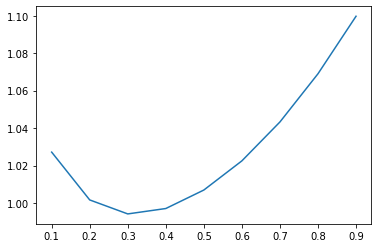

In [154]:
plt.plot(ema_scores.keys(), ema_scores.values())
plt.show()

The best score:

In [155]:
min(ema_scores.values())

0.9941518427652923

The ema_koeff equals 0.3. So the ema model is better than partly const and ema model and the model with linear regression.

# final predictions

In [34]:
final_model = EMAModel(ema_koeff=0.3)

In [35]:
final_model.fit(X, y)

In [36]:
final_prediction = final_model.predict(X_test)

In [37]:
submit(final_prediction)

'data/my_submission_32.csv'

The score is 1.05381. It is greater than the score of the model fitted on the dataset with lag features and some categories. It is obviously because EMA is a simple algorithm and the dataset doesn't contain information about items, their categories and shops.